**<font size="6" color=#33053E><b>Project-P2</b></font>**

**<font size="5" color=#211C4C>Collaborators:</font>**  
*<font size="3" color=#401655>Erfan Ahmadi, 81010078</font>*<br>
*<font size="3" color=#401655>Arash Shahin, 810199442</font>*<br>
*<font size="3" color=#401655>Hamed Miramirkhani, 810199500</font>*

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

In [36]:
df = pd.read_csv('letterbxd_preprocessed.csv')

In [ ]:
df.head(10)

As we can see we don't really need to do any preprocessing so we'll skip to feature engineering instead

## Feature Engineering and Selection

In [37]:
columns_of_interest = ['Genre', 'Studio', 'Country', 'Primary Language']
unique_values = {col: df[col].unique() for col in columns_of_interest}
for col, values in unique_values.items():
    print(f"Unique values in '{col}': {values}")

Unique values in 'Genre': ['Comedy' 'Science Fiction' 'Drama' 'Crime' 'Adventure' 'Mystery' 'Horror'
 'Action' 'Animation' 'Romance' 'Family' 'Thriller' 'War' 'Fantasy'
 'History' 'Western' 'Music' 'TV Movie']
Unique values in 'Studio': ['LuckyChap Entertainment' 'Barunson E&A' 'IAC Films' ...
 'Pure Flix Entertainment' 'Haunted Gay Ride Productions'
 'Jerry Gershwin Productions']
Unique values in 'Country': ['UK' 'South Korea' 'USA' 'Germany' 'Hong Kong' 'Canada' 'Sweden'
 'Ireland' 'Japan' 'China' 'France' 'Brazil' 'Czechia' 'New Zealand'
 'Australia' 'India' 'Italy' 'Austria' 'Poland' 'Spain' 'Denmark'
 'Colombia' 'Belgium' 'Netherlands' 'Czechoslovakia' 'Bahamas' 'Turkey'
 'United Arab Emirates' 'Mexico' 'USSR' 'Taiwan' 'South Africa' 'Hungary'
 'Chile' 'Finland' 'Serbia' 'Bulgaria' 'Argentina' 'Russian Federation'
 'Greece' 'Algeria' 'Switzerland' 'Bosnia and Herzegovina' 'Norway'
 'Pakistan' 'Iceland' 'Cuba' 'Dominican Republic' 'Iran' 'Indonesia'
 'Thailand' 'Jordan' 'Estonia' '

retrieves and prints the unique values present in the columns 'Genre', 'Studio', 'Country', and 'Primary Language' to understand the diversity and range of data within these categories. We can see that Studio has too many unique values so we'll have to figure something out when we want to encode it.

In [39]:
df.describe()

,Release Year,Avg Rating,Raters,Fans,Watched,Lists,Likes,Duration (minutes)
count,5782.000000,5782.000000,5.782000e+03,5782.000000,5.782000e+03,5782.000000,5.782000e+03,5782.000000
mean,2001.329644,3.370865,1.520578e+05,2011.408682,2.473017e+05,38644.395192,6.144624e+04,109.388620
std,20.439581,0.588133,2.773260e+05,8155.814601,4.403565e+05,54184.983922,1.488331e+05,24.411204
min,1911.000000,0.880000,1.408000e+03,0.000000,1.903000e+03,2585.000000,5.540000e+02,41.000000
25%,1992.000000,3.010000,2.739125e+04,64.000000,4.238000e+04,10916.250000,7.722000e+03,95.000000
50%,2007.000000,3.460000,5.542000e+04,221.000000,8.975950e+04,19220.500000,1.604300e+04,105.000000
75%,2017.000000,3.810000,1.371162e+05,852.750000,2.294178e+05,40741.750000,4.420625e+04,120.000000
max,2024.000000,4.640000,2.980018e+06,204000.000000,3.802316e+06,521089.000000,2.176138e+06,743.000000


We wanted to see what the means and IQR for each of the numerical columns are, specifically duration for feature engineering

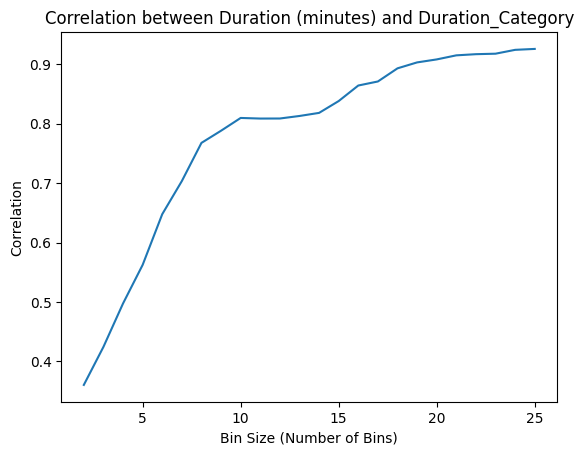

In [40]:
bin_sizes = range(2, 26)
correlations = []

for bin_size in bin_sizes:
    bin_edges = np.linspace(min(df['Duration (minutes)']), max(df['Duration (minutes)']), bin_size + 1)
    df['Duration_Category'] = pd.cut(df['Duration (minutes)'], bins=bin_edges, include_lowest=True)
    
    encoder = OrdinalEncoder()
    df['Duration_Category_Encoded'] = encoder.fit_transform(df[['Duration_Category']])
    
    corr = df['Duration (minutes)'].corr(df['Duration_Category_Encoded'])
    correlations.append(corr)
    df = df.drop(['Duration_Category', 'Duration_Category_Encoded'], axis=1)

plt.plot(bin_sizes, correlations)
plt.xlabel('Bin Size (Number of Bins)')
plt.ylabel('Correlation')
plt.title('Correlation between Duration (minutes) and Duration_Category')
plt.show()

This snippet aims to investigate the relationship between the duration of events (in minutes) and their categorized versions by varying the number of bins used. The main objective is to understand how the number of bins (or boxes) affects the correlation between the original duration values and their categorized representations. 

In [41]:
df['Positive Engagement Ratio'] = (df['Likes'] + df['Fans']) / df['Watched']
df['Fan Ratio'] = df['Fans'] / df['Watched']
df['Negative Engagement Ratio Estimation'] =  (df['Raters'] - df['Likes']) / df['Watched']
df['Total Engagement'] = df['Raters'] + df['Watched'] + df['Lists'] + df['Likes'] + df['Fans']
#df['Duration Category'] = pd.cut(df['Duration (minutes)'], bins=[0, 60, 90, 100, 110, 120, 150, 180, df['Duration (minutes)'].max()], 
#                                 labels=['Very Short', 'Short', 'Below Average', 'Average', 'Above Average', 'Long', 'Very Long', 'Epic'] , 
#                                         include_lowest=True)
#df['Decade'] = pd.cut(df['Release Year'], bins=[1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020, 2030], 
#                      labels=['1910s', '1920s', '1930s', '1940s', '1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s', '2020s'], right=False)


**Positive Engagement Ratio:** This calculates the ratio of positive engagements (Likes and Fans) to the number of times a movie was watched. It gives an indication of how positively the audience engaged with the movie relative to its viewership.

**Fan Ratio:** This calculates the ratio of Fans to the number of times the movie was watched. It provides insight into how many viewers became fans after watching the movie.

**Negative Engagement Ratio Estimation:** This estimates the ratio of negative engagements by considering the number of raters who did not like the movie. It is an indirect measure and can be useful to gauge potential negative feedback

**Total Engagement:** This sums up all types of interactions with the movie, providing a measure of total audience engagement. It includes ratings, viewings, additions to lists, likes, and fans.

**Duration Category and Decades:** We did not add these features in the end for the following reasons:

*Subjectivity:* The chosen bins and labels are somewhat arbitrary and may not reflect industry standards or audience perceptions.

*Granularity:* The categories may be too broad or too narrow for meaningful analysis. For example, the difference between "Above Average" and "Long" might not be significant.

*Data Distribution:* If the distribution of movie durations is not uniform, some categories might end up with very few entries, leading to sparse data and less reliable analysis.

*Uniformity:* The relevance and characteristics of movies can change significantly from one decade to another. Grouping movies by decade for example might obscure important trends and differences within shorter time spans.

*Data Sparsity:* Similar to the duration category, some decades might have very few movies, leading to sparsity issues.

In [42]:
df.head(10)

,Movie Name,Genre,Studio,Country,Primary Language,Release Year,Avg Rating,Raters,Fans,Watched,Lists,Likes,Duration (minutes),Positive Engagement Ratio,Fan Ratio,Negative Engagement Ratio Estimation,Total Engagement
0,Barbie,Comedy,LuckyChap Entertainment,UK,English,2023,3.86,2980018,26000,3658001,448304,1586062,114,0.440695,0.007108,0.381070,8698385
1,Parasite,Comedy,Barunson E&A,South Korea,Korean,2019,4.56,2844133,90000,3801915,521089,2176138,133,0.596052,0.023672,0.175700,9433275
2,Everything Everywhere All at Once,Science Fiction,IAC Films,USA,English,2022,4.30,2345715,130000,2908165,494949,1473174,140,0.551267,0.044702,0.300031,7352003
3,Fight Club,Drama,Fox 2000 Pictures,Germany,English,1999,4.27,2568765,114000,3726744,415981,1719180,139,0.491899,0.030590,0.227970,8544670
4,La La Land,Drama,Summit Entertainment,Hong Kong,English,2016,4.09,2285536,204000,3199145,462742,1422472,129,0.508408,0.063767,0.269780,7573895
5,Oppenheimer,Drama,Syncopy,UK,English,2023,4.23,2163845,31000,2611340,472979,1046979,181,0.412807,0.011871,0.427698,6326143
6,Interstellar,Science Fiction,Legendary Pictures,UK,English,2014,4.35,2445086,194000,3493990,445197,1621993,169,0.519748,0.055524,0.235574,8200266
7,Joker,Crime,Warner Bros. Pictures,Canada,English,2019,3.84,2646583,23000,3802316,290806,1552543,122,0.414364,0.006049,0.287730,8315248
8,Dune,Science Fiction,Legendary Pictures,USA,English,2021,3.90,2198100,22000,2847537,335566,1059535,155,0.379814,0.007726,0.399842,6462738
9,Spider-Man: Into the Spider-Verse,Adventure,Columbia Pictures,USA,English,2018,4.42,2445436,76000,3415337,444758,1757390,117,0.536811,0.022253,0.201458,8138921


In [43]:
df.describe()

,Release Year,Avg Rating,Raters,Fans,Watched,Lists,Likes,Duration (minutes),Positive Engagement Ratio,Fan Ratio,Negative Engagement Ratio Estimation,Total Engagement
count,5782.000000,5782.000000,5.782000e+03,5782.000000,5.782000e+03,5782.000000,5.782000e+03,5782.000000,5782.000000,5782.000000,5782.000000,5.782000e+03
mean,2001.329644,3.370865,1.520578e+05,2011.408682,2.473017e+05,38644.395192,6.144624e+04,109.388620,0.222179,0.005811,0.423200,5.014616e+05
std,20.439581,0.588133,2.773260e+05,8155.814601,4.403565e+05,54184.983922,1.488331e+05,24.411204,0.097333,0.008578,0.101822,9.141871e+05
min,1911.000000,0.880000,1.408000e+03,0.000000,1.903000e+03,2585.000000,5.540000e+02,41.000000,0.026189,0.000000,0.168047,8.274000e+03
25%,1992.000000,3.010000,2.739125e+04,64.000000,4.238000e+04,10916.250000,7.722000e+03,95.000000,0.145246,0.000824,0.352669,9.109925e+04
50%,2007.000000,3.460000,5.542000e+04,221.000000,8.975950e+04,19220.500000,1.604300e+04,105.000000,0.215258,0.002555,0.409906,1.838460e+05
75%,2017.000000,3.810000,1.371162e+05,852.750000,2.294178e+05,40741.750000,4.420625e+04,120.000000,0.287456,0.007176,0.480507,4.507748e+05
max,2024.000000,4.640000,2.980018e+06,204000.000000,3.802316e+06,521089.000000,2.176138e+06,743.000000,0.596052,0.106649,0.813501,9.433275e+06


We've printed out the statistics and the top 10 rows again to check the new features we've added

In [44]:
def plot_features(df, title_test_ = 'Feature Plots', top_n=10, nrows=5, ncols=4):
    fig = make_subplots(rows=nrows, cols=ncols, subplot_titles=[col for col in df.columns]) #, horizontal_spacing=0.1, vertical_spacing=0.15
    row, col = 1, 1

    for column in df.columns:
        if df[column].dtype == 'object' or df[column].dtype == 'category':
            top_10 = df[column].value_counts().nlargest(top_n)
            fig.add_trace(
                go.Bar(x=top_10.values, y=top_10.index, orientation='h', text=top_10.values, textposition='auto'),
                row=row, col=col
            )
            fig.update_xaxes(title_text='Frequency', row=row, col=col)
            fig.update_yaxes(title_text=column, row=row, col=col)
        else:
            fig.add_trace(
                go.Histogram(x=df[column], nbinsx=50, name=column),
                row=row, col=col
            )
            fig.update_xaxes(title_text=column, row=row, col=col)
            fig.update_yaxes(title_text='Frequency', row=row, col=col)

        if col == ncols:
            row += 1
            col = 1
        else:
            col += 1

    fig.update_layout(
        height=1250, width=2000, title_text=title_test_,
    )
    fig.show()


This code snippet generates plots for various features within a given dataframe. It allows visualizing different types of data distributions:

1. For categorical or string-type features, horizontal bar charts are plotted showing the top 10 most frequent values.
2. For numerical features, histograms with 50 bins are plotted to display the distribution of values.

The function `plot_features` organizes these plots into a grid layout (`nrows` by `ncols`) based on the number of columns in the dataframe. Each subplot title corresponds to a column name in the dataframe. This visualization approach helps in exploring and understanding the data distribution across different features effectively and helps us see if there's any more features we can add or see if we should do logarithmic transformations for columns with lots of high value numbers.

In [45]:
plot_features(df)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 17 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Movie Name                            5782 non-null   object 
 1   Genre                                 5782 non-null   object 
 2   Studio                                5782 non-null   object 
 3   Country                               5782 non-null   object 
 4   Primary Language                      5782 non-null   object 
 5   Release Year                          5782 non-null   int64  
 6   Avg Rating                            5782 non-null   float64
 7   Raters                                5782 non-null   int64  
 8   Fans                                  5782 non-null   int64  
 9   Watched                               5782 non-null   int64  
 10  Lists                                 5782 non-null   int64  
 11  Likes            

Here we can see that all of our types are correct and that we don't have any accidental null columns we need to remove.

In [47]:
top_categories = df['Studio'].value_counts().nlargest(30).index
df['Studio'] = df['Studio'].apply(lambda x: x if x in top_categories else 'Other')

categorical_columns = ['Genre', 'Country', 'Primary Language', 'Studio']
df = pd.get_dummies(df, columns=categorical_columns)

## Ordinal encoding for 'Decade'
#decade_order = ['1910s', '1920s', '1930s', '1940s', '1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s', '2020s']
#decade_mapping = {decade: i for i, decade in enumerate(decade_order, start=0)}
#df['Decade'] = df['Decade'].map(decade_mapping)
#df['Decade'] = df['Decade'].astype('category').cat.codes
#
## Ordinal encoding for 'Duration_Cat'
#duration_order = labels=['Very Short', 'Short', 'Below Average', 'Average', 'Above Average', 'Long', 'Very Long', 'Epic'] 
#duration_mapping = {duration: i for i, duration in enumerate(duration_order, start=0)}
#df['Duration Category'] = df['Duration Category'].map(duration_mapping)
#df['Duration Category'] = df['Duration Category'].astype('category').cat.codes

df = df.drop(columns=['Movie Name', 'Watched', 'Lists', 'Likes', 'Raters']) #, 'Duration (minutes)', 'Release Year'

epsilon = 1e-6
df['Total Engagement'] = np.log(df['Total Engagement'] + epsilon)
df['Fans'] = np.log(df['Fans'] + epsilon)

df_numeric = df.select_dtypes(include=['number'])  
scaler = RobustScaler()
df_numeric_scaled = pd.DataFrame(scaler.fit_transform(df_numeric), columns=df_numeric.columns)
df = pd.concat([df_numeric_scaled, df[df.select_dtypes(exclude=['number']).columns]], axis=1)

1. **Top Categories Selection**: It identifies the top 30 most frequent values in the 'Studio' column and replaces all other values with 'Other' to simplify the categorical data and avoid bloating columns after the one hot encoding.

2. **One-Hot Encoding**: Categorical columns ('Genre', 'Country', 'Primary Language', 'Studio') are converted into binary indicators using one-hot encoding as they lack any particular order.

3. **Column Removal**: The features 'Watched', 'Lists', 'Likes', and 'Raters' were dropped due to their high correlation. These features were identified to have strong interdependencies that could potentially lead to multicollinearity issues in the analysis. We removed 'Movie Name' as well because it had too many unique values and was more similar to an id than a feature.

4. **Log Transformation**: Numeric features 'Total Engagement' and 'Fans' undergo a logarithmic transformation to scale their distributions, aiding in modeling performance.

5. **Scaling**: Numeric features are scaled using the RobustScaler to normalize their values and mitigate the impact of outliers.

these steps prepare the data for models by reducing categorical complexity, handling numerical distributions, and improving feature scaling and relevance.

In [48]:
df.head(10)

,Release Year,Avg Rating,Fans,Duration (minutes),Positive Engagement Ratio,Fan Ratio,Negative Engagement Ratio Estimation,Total Engagement,Genre_Action,Genre_Adventure,...,Studio_TOHO,Studio_Touchstone Pictures,Studio_TriStar Pictures,Studio_United Artists,Studio_Universal Pictures,Studio_Village Roadshow Pictures,Studio_Walt Disney Pictures,Studio_Walt Disney Productions,Studio_Warner Bros. Pictures,Studio_Working Title Films
0,0.64,0.5000,1.841103,0.36,1.585240,0.716590,-0.225560,2.411976,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0.48,1.3750,2.320606,1.12,2.677689,3.323967,-1.832053,2.462699,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0.60,1.0500,2.462608,1.40,2.362766,6.634146,-0.859479,2.306809,False,False,...,False,False,False,False,False,False,False,False,False,False
3,-0.32,1.0125,2.411890,1.36,1.945298,4.412817,-1.423175,2.400826,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0.36,0.7875,2.636607,0.96,2.061393,9.635156,-1.096122,2.325405,False,False,...,False,False,False,False,False,False,False,False,False,False
5,0.64,0.9625,1.909025,3.04,1.389136,1.466412,0.139183,2.212825,False,False,...,False,False,False,False,False,False,False,False,False,False
6,0.28,1.1125,2.617198,2.56,2.141129,8.337632,-1.363692,2.375097,False,False,...,False,False,False,False,False,False,False,False,False,False
7,0.48,0.4750,1.793758,0.68,1.400086,0.549934,-0.955707,2.383805,False,False,...,False,False,False,False,False,False,False,False,True,False
8,0.56,0.5500,1.776593,2.00,1.157136,0.813910,-0.078721,2.226185,False,False,...,False,False,False,False,False,False,False,False,False,False
9,0.44,1.2000,2.255315,0.48,2.261115,3.100494,-1.630563,2.370401,False,True,...,False,False,False,False,False,False,False,False,False,False


here we can see that we've properly scaled all numerical columns and have one hot encoded all of our categorical columns.

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Columns: 175 entries, Release Year to Studio_Working Title Films
dtypes: bool(167), float64(8)
memory usage: 1.3 MB


We can see that we have a lot of features mostly thanks to our one hot encoding

In [50]:
def plot_correlation_heatmap(df):
    numeric_df = df.select_dtypes(include=['number'])
    corr_matrix = numeric_df.corr()
    annotations = []
    for x in range(len(corr_matrix.columns)):
        for y in range(len(corr_matrix.columns)):
            annotations.append(
                dict(
                    x=corr_matrix.columns[y],
                    y=corr_matrix.columns[x],
                    text=f"{corr_matrix.values[x, y]:.2f}",
                    showarrow=False,
                    font=dict(color='black')
                )
            )

    fig = go.Figure(data=go.Heatmap(
        z=corr_matrix.values,
        x=corr_matrix.columns,
        y=corr_matrix.columns,
        colorscale='Viridis',
        colorbar=dict(title='Correlation')
    ))

    # Add annotations
    fig.update_layout(
        title='Correlation Heatmap',
        width=800,
        height=800,
        annotations=annotations
    )

    fig.show()

`plot_correlation_heatmap` generates a heatmap visualization of the correlation matrix for numerical features in the input dataframe. This function aids in visually assessing the strength and direction of relationships between different numerical features in the dataset, facilitating insights into data patterns and potential dependencies.

In [51]:
plot_correlation_heatmap(df)

#### Negative Correlations

1. **Average Rating vs. Release Year (-0.40)**
   **Interpretation**: The negative correlation between Average Rating and Release Year suggests that more recent movies tend to have lower average ratings. This trend could be due to various factors, such as changing audience preferences, more critical rating behavior over time, lower quality of modern movies, or lack of worse older movies in our dataset as we only have the most popular movies of Letterboxd and older worse movies are most likely forgotten completely, as opposed to new bad movies that might even get "hate watched".

2. **Negative Engagement Ratio Estimation vs. Fan Ratio (-0.43)**
   **Interpretation**: This negative correlation implies that as the estimated negative engagement (dislikes or non-likes) increases, the proportion of fans to views decreases. This could mean that movies with higher negative engagement are less likely to convert viewers into fans.

3. **Positive Engagement Ratio vs. Negative Engagement Ratio Estimation (-0.40)**
   **Interpretation**: The moderate negative correlation between Positive and Negative Engagement Ratios suggests that movies with higher positive engagement tend to have lower negative engagement. This relationship highlights the inverse nature of positive and negative audience reactions.
   
4. **Negative Engagement Ratio Estimation vs. Average Rating (-0.55)**
   **Interpretation:** The strong negative correlation between Negative Engagement Ratio Estimation and Average Rating indicates that movies with higher average ratings tend to have lower negative engagement. This suggests that higher-rated movies are generally better received, leading to fewer dislikes or negative reactions.

#### Positive Correlations

1. **Positive Engagement Ratio vs. Average Rating (0.84)**
   **Interpretation**: This strong positive correlation indicates that movies with higher Positive Engagement Ratios also tend to have higher Average Ratings. It suggests that positive engagement (likes and fans per view) is a good indicator of the overall quality as perceived by the audience.

2. **Total Engagement vs. Fans (0.70)**
   **Interpretation**: A strong positive correlation between Total Engagement (combined interactions such as ratings, views, lists, likes, and fans) and the number of Fans indicates that more overall engagement generally leads to a larger fan base.

3. **Fan Ratio vs. Fans (0.59)**
   **Interpretation**: This positive correlation shows that a higher proportion of fans per view is associated with a greater absolute number of fans. This relationship underscores the importance of converting viewers into fans to build a larger audience.

4. **Positive Engagement Ratio vs. Fans (0.60)**
   **Interpretation**: The positive correlation here reinforces the idea that movies with higher positive engagement metrics (likes and fans per view) tend to attract more fans overall.

There is a complex relationship between engagement metrics and average ratings, with both positive and negative correlations observed.

These insights can inform strategies to enhance movie popularity and engagement, focusing on increasing positive interactions and understanding audience trends.

In [52]:
def plot_pairplot(df, color=None):
    numerical_df = df.select_dtypes(include=['number'])
    fig = px.scatter_matrix(numerical_df, color=color)
    fig.update_layout(title="Pair Plot of Numerical Features", height=800, width=800)
    fig.show()

This function generates a pair plot, also known as a scatter matrix, to visualize relationships between numerical features in the dataset. Each scatter plot in the matrix represents the relationship between two different numerical variables. Optionally, it can colorize the plots based on a specified categorical variable. This visualization tool aids in exploring correlations and distributions between numerical variables, facilitating insights into their interactions and patterns within the dataset.

In [53]:
plot_pairplot(df)

### Evaluation Metric
We've chosen R2 and MSE for evaluation and here's why:

**R2:** R² measures the proportion of the variance in the dependent variable (target) that is predictable from the independent variables (features). It provides an intuitive measure of how well the model fits the data. A higher R² value indicates that the model explains a larger proportion of the variance in the target variable. This is particularly useful when the goal is to understand the overall goodness-of-fit of the regression model.

**Mean Squared Error (MSE)**: MSE calculates the average squared difference between the predicted values and the actual values. It penalizes larger errors more significantly than smaller ones. MSE gives a precise measure of the average magnitude of errors produced by the model. It provides a clear understanding of how close the predicted values are to the actual values in terms of their square differences.

**Why these metrics might be better than others:**

*Comprehensiveness:* Together, R2 and MSE cover different aspects of model performance. R2 assesses the overall fit, while MSE provides a detailed measure of the prediction accuracy in terms of error magnitude.

*Interpretability:* Both metrics are easy to interpret. R2 gives a percentage that represents the variance explained by the model, where a higher value indicates a better fit. MSE, on the other hand, gives a concrete measure of how far off the model's predictions are from the actual values, in squared units.

*Standard Practice:* R2 and MSE are widely used in regression analysis and are well-understood in both academic and practical settings. They provide a standard benchmark for evaluating regression models across different domains.

*Clear Objective:* R2 and MSE directly measure aspects critical to that objective — overall fit and prediction accuracy.

### Model Training


- **Support Vector Machine (SVM)**: SVM for regression aims to find a hyperplane that best fits the data points while maximizing the margin between the data points and the hyperplane. It uses a loss function that penalizes deviations from the hyperplane, and a kernel function can be employed to handle nonlinear relationships.

- **Linear Regression**: Linear regression models the relationship between dependent variables (outputs) and independent variables (inputs) by fitting a linear equation to the observed data. It aims to minimize the sum of squared differences between predicted and actual values. It's straightforward and interpretable but assumes a linear relationship between variables.

- **K-Nearest Neighbors (KNN)**: KNN for regression predicts the value of a new data point by averaging the values of its k nearest neighbors. It makes no assumptions about the underlying data distribution and can capture complex relationships. However, it can be computationally expensive with large datasets.

- **Decision Tree**: Decision trees recursively partition the data into subsets based on the most significant attribute splits. For regression, each leaf node predicts the average value of the training instances that fall into that region. They are intuitive and can capture complex interactions but are prone to overfitting without proper pruning.

- **Neural Networks**: Neural networks for regression consist of interconnected layers of nodes (neurons) that process input data and generate output predictions. They can model highly nonlinear relationships and learn intricate patterns in data. However, they require a large amount of data for training, and their architecture and hyperparameters need careful tuning to prevent overfitting.

In [54]:
class NeuralNetworkModel:
    def __init__(self):
        self.model = None
        self.history = None
        self.best_params = None

    def build_model(self, input_dim, layers=1, units=64, activation='relu', optimizer='adam', learning_rate=0.001):
        model = Sequential()
        model.add(Dense(units, input_dim=input_dim, activation=activation))
        for _ in range(layers - 1):
            model.add(Dense(units, activation=activation))
        model.add(Dense(1))
        
        if optimizer == 'adam':
            opt = Adam(learning_rate=learning_rate)
        elif optimizer == 'sgd':
            opt = SGD(learning_rate=learning_rate)
        elif optimizer == 'rmsprop':
            opt = RMSprop(learning_rate=learning_rate)
        else:
            raise ValueError("Invalid optimizer specified.")
        
        model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mean_squared_error'])
        return model
    
    def plot_true_vs_pred(self, y_true, y_pred):
        plt.scatter(y_true, y_pred, color='blue', label="Neural Network")
        plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linewidth=2)
        plt.xlabel("True Values")
        plt.ylabel("Predicted Values")
        plt.title("Neural Network")
        plt.legend()
        plt.show()
    
    def train(self, X_train, y_train, X_val, y_val):
        if self.best_params is not None:
            layers = self.best_params['layers']
            units = self.best_params['units']
            activation = self.best_params['activation']
            learning_rate = self.best_params['learning_rate']
            optimizer = self.best_params['optimizer']
            epochs = self.best_params['epochs']
            batch_size = self.best_params['batch_size']
        else:
            layers = 1
            units = 64
            activation = 'relu'
            learning_rate = 0.001
            optimizer = 'adam'
            epochs = 100
            batch_size = 32

        self.model = self.build_model(input_dim=X_train.shape[1], layers=layers, units=units, activation=activation, optimizer=optimizer, learning_rate=learning_rate)
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        self.history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=0)
    
    def predict(self, X):
        return self.model.predict(X)
    
    def plot_error(self):
        plt.plot(self.history.history['loss'], label='Train Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()
    
    def evaluate(self, y_test, y_pred):
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        return mse, r2

    def hyperparameter_tuning(self, X_train, y_train):
        def create_model(layers=1, units=64, activation='relu', optimizer='adam', learning_rate=0.001):
            return self.build_model(input_dim=X_train.shape[1], layers=layers, units=units, activation=activation, optimizer=optimizer, learning_rate=learning_rate)
        
        layers_map = {0: 1, 1: 2, 2: 3, 3: 4}
        units_map = {0: 16, 1: 32, 2: 64}
        activation_map = {0: 'relu', 1: 'tanh', 2: 'linear'}
        optimizer_map = {0: 'adam', 1: 'sgd', 2: 'rmsprop'}
        batch_size_map = {0: 16, 1: 32, 2: 64, 3: 128}
        epochs_map = {0: 50, 1: 100}

        space = {
            'layers': hp.choice('layers', layers_map.values()),
            'units': hp.choice('units', units_map.values()),
            'activation': hp.choice('activation', activation_map.values()),
            'optimizer': hp.choice('optimizer', optimizer_map.values()),
            'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-1)),
            'batch_size': hp.choice('batch_size', batch_size_map.values()),
            'epochs': hp.choice('epochs', epochs_map.values()),
        }

        def objective(params):
            early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
            model = KerasRegressor(build_fn=create_model, layers=params['layers'], units=params['units'], activation=params['activation'], optimizer=params['optimizer'], learning_rate=params['learning_rate'], verbose=0)
            scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, fit_params={'batch_size': params['batch_size'], 'epochs': params['epochs'], 'callbacks': [early_stopping]})
            mean_score = np.mean(scores)
            return {'loss': -mean_score, 'status': STATUS_OK}
        
        trials = Trials()
        best = fmin(objective, space, algo=tpe.suggest, max_evals=50, trials=trials)

        best_params = {
            'layers': layers_map[best['layers']],
            'units': units_map[best['units']],
            'activation': activation_map[best['activation']],
            'optimizer': optimizer_map[best['optimizer']],
            'learning_rate': best['learning_rate'],
            'batch_size': batch_size_map[best['batch_size']],
            'epochs': epochs_map[best['epochs']],
        }
        self.best_params = best_params

The `NeuralNetworkModel` class is designed to manage a neural network model using the Keras and TensorFlow libraries. Below are its key features:

**Model Building**: It defines a neural network architecture using the `build_model` function, allowing customization of layers, units, activation functions, optimizer, and learning rate.

**Training the Model**: The `train` function trains the model using training and validation data, incorporating early stopping and optimized parameters.

**Prediction**: The `predict` function performs predictions using the trained model.

**Evaluation**: Functions such as `evaluate` calculate evaluation metrics like Mean Squared Error (MSE) and R-squared (R2) to assess the model's performance.

**Hyperparameter Tuning**: The `hyperparameter_tuning` function optimizes model hyperparameters through hyperparameter search using TPE algorithm and various neural network architectures.

**Result Visualization**: Methods like `plot_true_vs_pred` and `plot_error` visualize predictions versus true values and training/validation errors, respectively.

This class facilitates the reconstruction, training, optimization, and evaluation of neural network models for predictive and data analysis tasks.

Here's the explanation for each hyperparameter Neural Network:

*layers:* Number of layers in the neural network

*units:* Number of neurons (units) in each layer.

*activation:* Activation function used in the layers.

`ReLU (Rectified Linear Unit):` Activation function that outputs the input directly if it is positive, otherwise, it outputs zero.

`Tanh (Hyperbolic Tangent):` Activation function that outputs values between -1 and 1, with a nonlinear S-shaped curve.

`Linear:` Activation function that outputs the input without any modification, used in regression tasks.

*optimizer:* Optimization algorithm used to update network weights.

`Adam (Adaptive Moment Estimation):` Optimization algorithm that combines the advantages of two other extensions of stochastic gradient descent: AdaGrad and RMSProp.

`SGD (Stochastic Gradient Descent):` Optimization algorithm that updates the model parameters using the gradient of the loss function with respect to a single or a few training samples.

`RMSProp (Root Mean Square Propagation):` Optimization algorithm that adjusts the learning rate for each parameter individually based on a moving average of recent gradients.

*batch_size:* Number of training samples used in one forward/backward pass.

*epochs:* Number of complete passes through the training dataset.



In [55]:
class LinearModel:
    def __init__(self):
        self.model = LinearRegression()
        self.best_params = None
        
    def train(self, X_train, y_train):
        if self.best_params:
            self.model.set_params(**self.best_params)
        self.model.fit(X_train, y_train)
    
    def predict(self, X):
        return self.model.predict(X)
    
    def plot_true_vs_pred(self, y_true, y_pred):
        plt.scatter(y_true, y_pred, color='blue', label= "Linear Regression")
        plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linewidth=2)
        plt.xlabel("True Values")
        plt.ylabel("Predicted Values")
        plt.title("Linear Regression")
        plt.legend()
        plt.show()
    
    def plot_error(self, y_true, y_pred):
        plt.plot(y_true, y_true - y_pred, 'bo')
        plt.xlabel('True Values')
        plt.ylabel('Residual')
        plt.title('Linear Regression Residual Plot')
        plt.show()
    
    def evaluate(self, y_test, y_pred):
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        return mse, r2
    
    def hyperparameter_tuning(self, X_train, y_train):
        param_grid = {
            'fit_intercept': [True, False]
        }
        grid_search = GridSearchCV(LinearRegression(), param_grid, cv=5)
        grid_search.fit(X_train, y_train)
        self.best_params = grid_search.best_params_

The `LinearModel` class encapsulates functionalities related to linear regression modeling. Key features include:

**Initialization**: It initializes with an instance of `LinearRegression()` and keeps track of the best hyperparameters found during tuning.

**Training**: The `train` method fits the linear regression model to the provided training data. If `best_params` are available, it adjusts the model accordingly.

**Prediction**: Using the `predict` method, it predicts target values based on input features.

**Visualization**: Methods like `plot_true_vs_pred` display a scatter plot comparing true versus predicted values, and `plot_error` shows a residual plot illustrating prediction errors.

**Evaluation**: The `evaluate` method computes Mean Squared Error (MSE) and R-squared (R2) scores to assess the model's performance.

**Hyperparameter Tuning**: The `hyperparameter_tuning` method uses GridSearchCV to find the optimal `fit_intercept` parameter for the linear regression model. (Determines whether to calculate the intercept (bias term) in the linear regression model)

This class serves to construct, optimize, and evaluate linear regression models for various predictive tasks.

In [56]:
class SVMModel:
    def __init__(self):
        self.model = SVR()
        self.best_params = None
    
    def train(self, X_train, y_train):
        if self.best_params:
            self.model.set_params(**self.best_params)
        self.model.fit(X_train, y_train)
    
    def predict(self, X):
        return self.model.predict(X)
    
    def plot_true_vs_pred(self, y_true, y_pred):
        plt.scatter(y_true, y_pred, color='blue', label= "SVM")
        plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linewidth=2)
        plt.xlabel("True Values")
        plt.ylabel("Predicted Values")
        plt.title("SVM")
        plt.legend()
        plt.show()
    
    def plot_error(self, y_true, y_pred):
        plt.plot(y_true, y_true - y_pred, 'bo')
        plt.xlabel('True Values')
        plt.ylabel('Residual')
        plt.title('SVM Residual Plot')
        plt.show()
    
    def evaluate(self, y_test, y_pred):
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        return mse, r2
    
    def hyperparameter_tuning(self, X_train, y_train):
        kernel_map = {0: 'linear', 1: 'poly', 2: 'rbf'}
        degree_map = {0: 2, 1: 3}

        space = {
            'C': hp.loguniform('C', np.log(0.1), np.log(100)),
            'kernel': hp.choice('kernel', kernel_map.values()),
            'degree': hp.choice('degree', degree_map.values()),
            'gamma': hp.loguniform('gamma', np.log(1e-4), np.log(1)),
            'coef0': hp.uniform('coef0', 0, 1),
            'tol': hp.loguniform('tol', np.log(1e-4), np.log(1e-1)),
        }
        def objective(params):
            model = SVR(**params)
            scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
            mean_score = np.mean(scores)
            return {'loss': -mean_score, 'status': STATUS_OK}
    
        trials = Trials()
        best = fmin(objective, space, algo=tpe.suggest, max_evals=50, trials=trials)
        
        best_params = {
            'C': best['C'],
            'kernel': kernel_map[best['kernel']],
            'degree': degree_map[best['degree']],
            'gamma':  best['gamma'],
            'coef0': best['coef0'],
            'tol': best['tol'],
        }
        self.best_params = best_params

The `SVMModel` class is designed for managing Support Vector Machine (SVM) regression models using the SVR (Support Vector Regressor) from scikit-learn. Key functionalities include:

**Initialization**: It initializes with an SVR model and tracks the best hyperparameters found during tuning.

**Training**: The `train` method fits the SVR model to the provided training data. If `best_params` are available, it adjusts the model accordingly.

**Prediction**: Using the `predict` method, it generates predictions based on input features.

**Visualization**: Methods like `plot_true_vs_pred` display a scatter plot comparing true versus predicted values, and `plot_error` shows a residual plot illustrating prediction errors.

**Evaluation**: The `evaluate` method computes Mean Squared Error (MSE) and R-squared (R2) scores to evaluate the model's predictive performance.

**Hyperparameter Tuning**: The `hyperparameter_tuning` method uses Bayesian optimization (via Hyperopt) to search for optimal hyperparameters:

`C (regularization parameter):` Controls the trade-off between achieving a low training error and a low testing error (regularization strength).

`kernel:` Specifies the kernel type to be used in the algorithm (e.g., 'linear', 'poly', 'rbf').

*Linear:* Kernel that computes a linear separation between data points, effectively mapping the data into the original feature space.

*Poly (Polynomial):* Kernel that computes a non-linear separation by mapping the original data into a higher-dimensional space using polynomial functions of the input features.

*RBF (Radial Basis Function):* Kernel that computes a non-linear separation by measuring the distance between data points and mapping them into an infinite-dimensional space using Gaussian functions, also known as the Gaussian kernel.

`degree (for polynomial kernel):` Degree of the polynomial kernel function (significant when using 'poly' kernel).

`gamma:` Defines how far the influence of a single training example reaches (affects the 'rbf', 'poly', and 'sigmoid' kernels).

`coef0:` Independent term in kernel function (used in 'poly' and 'sigmoid' kernels).

`tol:` Tolerance for stopping criterion (minimum change in the loss function).

This class facilitates the construction, tuning, evaluation, and visualization of SVM regression models for predictive tasks.

In [ ]:
class DecisionTreeModel:
    def __init__(self):
        self.model = DecisionTreeRegressor()
        self.best_params = None
    
    def train(self, X_train, y_train):
        if self.best_params:
            self.model.set_params(**self.best_params)
        self.model.fit(X_train, y_train)
    
    def predict(self, X):
        return self.model.predict(X)
    
    def plot_true_vs_pred(self, y_true, y_pred):
        plt.scatter(y_true, y_pred, color='blue', label= "Decision Tree")
        plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linewidth=2)
        plt.xlabel("True Values")
        plt.ylabel("Predicted Values")
        plt.title("Decision Tree")
        plt.legend()
        plt.show()
    
    def plot_error(self, y_true, y_pred):
        plt.plot(y_true, y_true - y_pred, 'bo')
        plt.xlabel('True Values')
        plt.ylabel('Residual')
        plt.title('Decision Tree Residual Plot')
        plt.show()
    
    def evaluate(self, y_test, y_pred):
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        return mse, r2
    
    def hyperparameter_tuning(self, X_train, y_train):
        criterion_map = {0: 'squared_error', 1: 'friedman_mse', 2: 'absolute_error'}
        splitter_map = {0: 'best', 1: 'random'}
        max_depth_map = {0: None, 1: 10, 2: 20, 3: 30}
        min_samples_split_map = {0: 2, 1: 5, 2: 10}
        min_samples_leaf_map = {0: 1, 1: 2, 2: 4}
        max_features_map = {0: None, 1: 'sqrt', 2: 'log2'}
        max_leaf_nodes_map = {0: None, 1: 10, 2: 20, 3: 30}
        space = {
            'criterion': hp.choice('criterion', criterion_map.values()),
            'splitter': hp.choice('splitter', splitter_map.values()),
            'max_depth': hp.choice('max_depth', max_depth_map.values()),
            'min_samples_split': hp.choice('min_samples_split', min_samples_split_map.values()),
            'min_samples_leaf': hp.choice('min_samples_leaf', min_samples_leaf_map.values()),
            'max_features': hp.choice('max_features', max_features_map.values()),
            'max_leaf_nodes': hp.choice('max_leaf_nodes', max_leaf_nodes_map.values()),
            'min_impurity_decrease': hp.loguniform('min_impurity_decrease', np.log(1e-8), np.log(1e-2)),
        }

        def objective(params):
            model = DecisionTreeRegressor(**params)
            scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
            mean_score = np.mean(scores)
            return {'loss': -mean_score, 'status': STATUS_OK}

        
        trials = Trials()
        best = fmin(objective, space, algo=tpe.suggest, max_evals=100, trials=trials)
        
        best_params = {
            'criterion': criterion_map[best['criterion']],
            'splitter': splitter_map[best['splitter']],
            'max_depth': max_depth_map[best['max_depth']],
            'min_samples_split': min_samples_split_map[best['min_samples_split']],
            'min_samples_leaf': min_samples_leaf_map[best['min_samples_leaf']],
            'max_features': max_features_map[best['max_features']],
            'max_leaf_nodes': max_leaf_nodes_map[best['max_leaf_nodes']],
            'min_impurity_decrease': best['min_impurity_decrease']
        }
        self.best_params = best_params

The `DecisionTreeModel` class facilitates the management of Decision Tree regression models using scikit-learn's `DecisionTreeRegressor`. Key features include:

**Initialization**: It initializes with a Decision Tree regressor model and maintains the best hyperparameters found during tuning.

**Training**: The `train` method trains the Decision Tree model on provided training data. If `best_params` are available, it configures the model with these parameters.

**Prediction**: Using the `predict` method, it generates predictions based on input features.

**Visualization**: Methods like `plot_true_vs_pred` display a scatter plot comparing true versus predicted values, and `plot_error` illustrates a residual plot depicting prediction errors.

**Evaluation**: The `evaluate` method computes Mean Squared Error (MSE) and R-squared (R2) scores to assess the model's predictive performance.

**Hyperparameter Tuning**: The `hyperparameter_tuning` method employs Bayesian optimization (via Hyperopt) to search for optimal hyperparameters:

*Criterion:* Function to measure the quality of a split. Examples include 'gini' for the Gini impurity and 'entropy' for information gain.

`squared_error:` Measures the mean squared error, suitable for regression tasks.

`friedman_mse:` Variant of mean squared error used in Friedman's gradient boosting framework.

`absolute_error:` Measures the mean absolute error, another option for regression tasks.

*Splitter:* Strategy for splitting nodes. Options are 'best' (chooses the best split) and 'random' (chooses the best random split).

`best:` Chooses the best split based on the chosen criterion.

`random:` Chooses the best random split among a random subset of features.

*max_depth:* Maximum depth of the tree. Limits the number of nodes from the root to the farthest leaf.

*min_samples_split:* Minimum number of samples required to split an internal node. Controls for overfitting by ensuring a minimum amount of samples in each split.

*min_samples_leaf:* Minimum number of samples required to be at a leaf node. Similar to min_samples_split but applies to leaf nodes.

*max_features:* Number of features to consider when looking for the best split. Can be an integer (number of features) or a fraction of total features.

`None:` Uses all features.

`sqrt:` Uses the square root of the total number of features.

`log2:` Uses the logarithm base 2 of the total number of features.

*max_leaf_nodes:* Maximum number of leaf nodes in the tree. Limits the growth of the tree.

*min_impurity_decrease:* A node will be split if this split induces a decrease of the impurity greater than or equal to this value.

This class facilitates the construction, tuning, evaluation, and visualization of Decision Tree regression models for various predictive tasks.

In [58]:
class KNNModel:
    def __init__(self):
        self.model = KNeighborsRegressor()
        self.best_params = None
        
    def train(self, X_train, y_train):
        if self.best_params:
            self.model.set_params(**self.best_params)
        self.model.fit(X_train, y_train)
    
    def predict(self, X):
        return self.model.predict(X)
    
    def plot_true_vs_pred(self, y_true, y_pred):
        plt.scatter(y_true, y_pred, color='blue', label= "KNN")
        plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linewidth=2)
        plt.xlabel("True Values")
        plt.ylabel("Predicted Values")
        plt.title("KNN")
        plt.legend()
        plt.show()

    def plot_error(self, y_true, y_pred):
        plt.plot(y_true, y_true - y_pred, 'bo')
        plt.xlabel('True Values')
        plt.ylabel('Residual')
        plt.title('KNN Residual Plot')
        plt.show()
    
    def evaluate(self, y_test, y_pred):
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        return mse, r2
    
    def hyperparameter_tuning(self, X_train, y_train):
        n_neighbors_map = {0: 3, 1: 5, 2: 10, 3: 20}
        weights_map = {0: 'uniform', 1: 'distance'}
        algorithm_map = {0: 'auto', 1: 'ball_tree', 2: 'kd_tree'}
        leaf_size_map = {0: 10, 1: 20, 2: 30}
        p_map = {0: 1, 1: 2}
        space = {
            'n_neighbors': hp.choice('n_neighbors', n_neighbors_map.values()),
            'weights': hp.choice('weights', weights_map.values()),
            'algorithm': hp.choice('algorithm', algorithm_map.values()),
            'leaf_size': hp.choice('leaf_size', leaf_size_map.values()),
            'p': hp.choice('p', p_map.values()),
        }

        def objective(params):
            model = KNeighborsRegressor(**params)
            scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
            mean_score = np.mean(scores)
            return {'loss': -mean_score, 'status': STATUS_OK}
        
        trials = Trials()
        best = fmin(objective, space, algo=tpe.suggest, max_evals=100, trials=trials)
        
        best_params = {
            'n_neighbors': n_neighbors_map[best['n_neighbors']],
            'weights': weights_map[best['weights']],
            'algorithm': algorithm_map[best['algorithm']],
            'leaf_size': leaf_size_map[best['leaf_size']],
            'p': p_map[best['p']]
        }
        self.best_params = best_params

The `KNNModel` class encapsulates functionalities for training, predicting, evaluating, and optimizing K-Nearest Neighbors (KNN) regression models using scikit-learn's `KNeighborsRegressor`.

**Initialization**: Upon instantiation, it initializes a KNN regressor model (`KNeighborsRegressor`) and maintains an attribute (`best_params`) to store the best hyperparameters found during tuning.

**Training**: The `train` method fits the KNN model to the provided training data (`X_train`, `y_train`). If `best_params` are set, it configures the model with these parameters before training.

**Prediction**: The `predict` method generates predictions for new input data (`X`) using the trained KNN model.

**Visualization**: Methods like `plot_true_vs_pred` display a scatter plot comparing true versus predicted values, and `plot_error` illustrates a residual plot depicting prediction errors.

**Evaluation**: The `evaluate` method computes Mean Squared Error (MSE) and R-squared (R2) scores to assess the performance of the KNN model on test data (`y_test`, `y_pred`).

**Hyperparameter Tuning**: The `hyperparameter_tuning` method utilizes Bayesian optimization (via Hyperopt) to search for optimal hyperparameters:

**n_neighbors:** Number of neighbors to consider for each query point. Determines how many nearest neighbors are used to make a prediction.

**weights:** Weight function used in prediction:

``uniform:`` All points in each neighborhood are weighted equally.

``distance:`` Weight points by the inverse of their distance. Closer neighbors have a greater influence on the prediction.

**algorithm:** Algorithm used to compute the nearest neighbors:

`auto:` Automatically chooses the most appropriate algorithm based on the values passed to fit method.

`ball_tree:` Uses BallTree data structure for efficient nearest neighbor search.

`kd_tree:` Uses KDTree data structure for efficient nearest neighbor search.

`brute:` Computes exact neighbors for each query point, which can be slow but straightforward for small datasets.

**leaf_size:** Leaf size passed to BallTree or KDTree. This parameter affects the construction and query time of the BallTree or KDTree data structures.

**p:** Power parameter for the Minkowski metric:

When p = 1, this corresponds to the Manhattan distance (L1 norm). (Distance between two points is the sum of the absolute differences of their Cartesian coordinates.)

When p = 2, this corresponds to the Euclidean distance (L2 norm). (Distance between two points is the straight-line distance, or the length of the line segment connecting them.)

For other values of p, it corresponds to the Minkowski distance metric. (Minkowski Distance: Generalization of both Manhattan and Euclidean distances, where pp determines the degree of the distance formula (e.g., p=1p=1 for Manhattan, p=2p=2 for Euclidean))

This class facilitates the construction, tuning, evaluation, and visualization of KNN regression models tailored for various predictive tasks.

In [59]:
def predict_with_tuning(Model, model_name, X_test, y_test, X_train, y_train):
    model = Model

    model.hyperparameter_tuning(X_train, y_train)
    model.train(X_train, y_train)
    prediction = model.predict(X_test)
    mse, r2 = model.evaluate(y_test, prediction)

    model.plot_error(y_test, prediction)
    model.plot_true_vs_pred(y_test, prediction)
    print("Best parameters for", model_name, ":", model.best_params)
    print(model_name, "MSE:", mse)
    print(model_name, "R2:", r2)

def predict_neural_network(Model, model_name, X_test, y_test, X_train, y_train):
    model = Model
    
    model.hyperparameter_tuning(X_train, y_train)
    model.train(X_train, y_train, X_test, y_test)
    prediction = model.predict(X_test)
    mse, r2 = model.evaluate(y_test, prediction)

    model.plot_error()
    model.plot_true_vs_pred(y_test, prediction)
    print("Best parameters for", model_name, ":", model.best_params)
    print(model_name, "MSE:", mse)
    print(model_name, "R2:", r2)


The `predict_with_tuning` function defines a process to evaluate and tune a machine learning model specified by `Model`. It begins by initializing the model and then conducts hyperparameter tuning using `model.hyperparameter_tuning(X_train, y_train)`, where `X_train` and `y_train` are the features and target values of the training dataset, respectively. Following tuning, the model is trained with `model.train(X_train, y_train)`, after which it predicts outcomes for the test dataset `X_test` using `model.predict(X_test)`. Subsequently, the function evaluates the model's predictions against the true values `y_test` using metrics like Mean Squared Error (MSE) and R-squared (R2) score via `model.evaluate(y_test, prediction)`. Visualizations of prediction errors and true versus predicted values are then generated with `model.plot_error(y_test, prediction)` and `model.plot_true_vs_pred(y_test, prediction)`. Finally, the function prints the best hyperparameters discovered during tuning (`model.best_params`), along with the MSE and R2 score of the model on the test data. `predict_neural_network` is very similar except during training we give it both the test and train dataset.


In [60]:
X = df.drop(columns=['Avg Rating'])
y = df['Avg Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

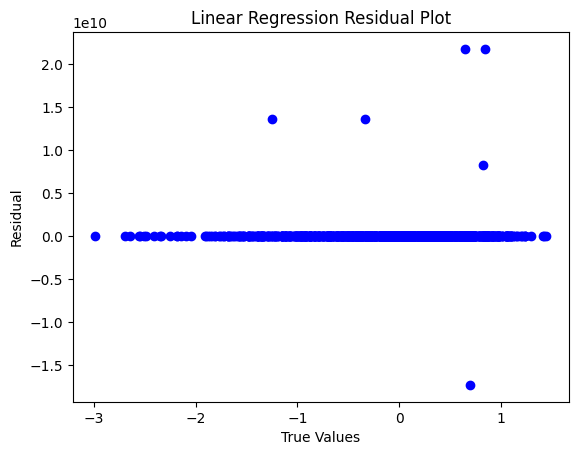

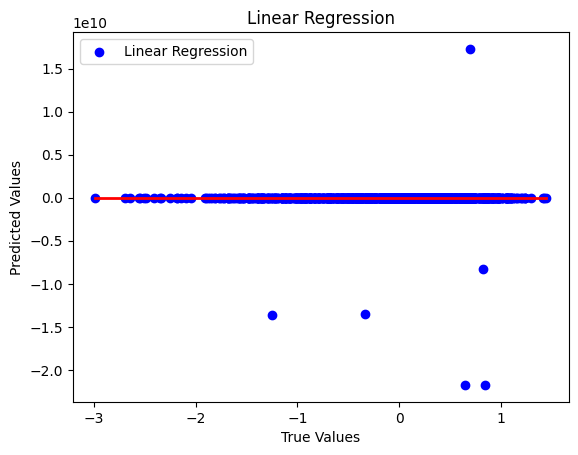

Best parameters for Linear Regression : {'fit_intercept': True}
Linear Regression MSE: 1.4548135694218079e+18
Linear Regression R2: -2.7307068814952376e+18
100%|██████████| 100/100 [1:15:17<00:00, 45.18s/trial, best loss: 0.047444912560625066] 


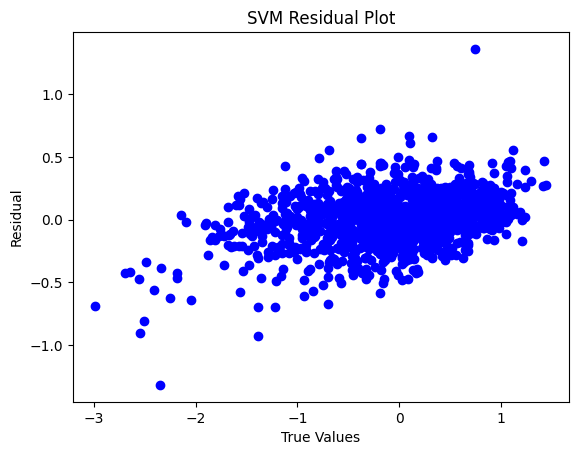

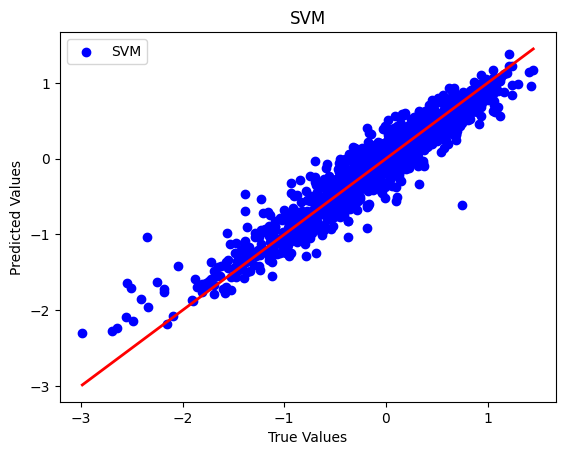

Best parameters for SVM : {'C': 7.140774310833681, 'kernel': 'rbf', 'degree': 2, 'gamma': 0.03792286376119295, 'coef0': 0.4286955979138276, 'tol': 0.02599901583269276}
SVM MSE: 0.04695705954707458
SVM R2: 0.9118608952135774
100%|██████████| 100/100 [04:36<00:00,  2.76s/trial, best loss: 0.11562066948679006]


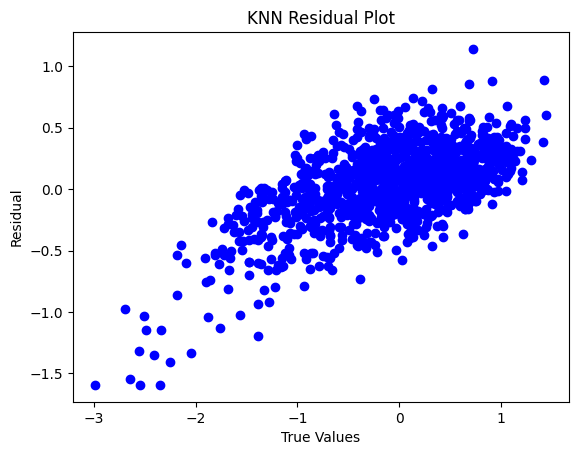

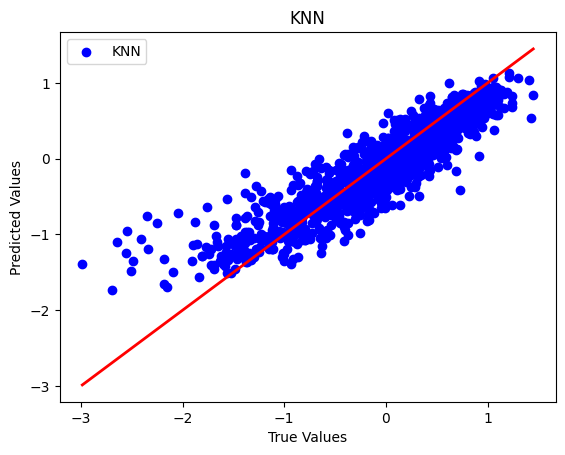

Best parameters for KNN : {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'kd_tree', 'leaf_size': 20, 'p': 1}
KNN MSE: 0.10784157301248723
KNN R2: 0.7975797506112706
100%|██████████| 100/100 [04:07<00:00,  2.48s/trial, best loss: 0.08278911317567564]


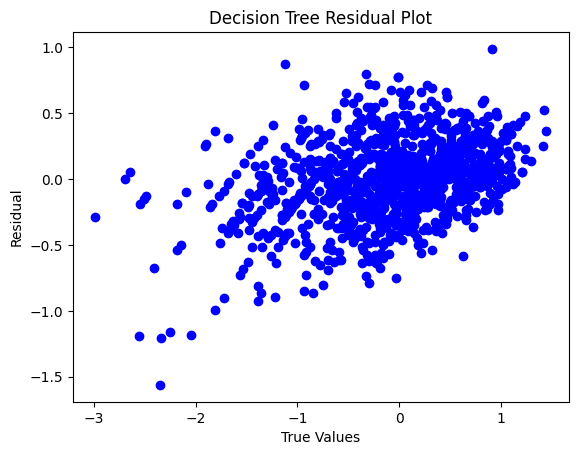

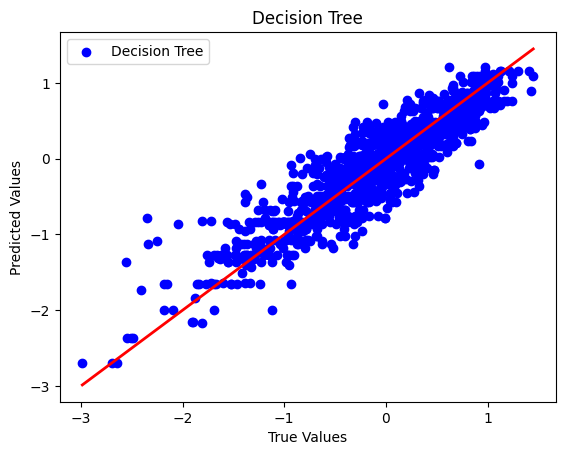

Best parameters for Decision Tree : {'criterion': 'absolute_error', 'splitter': 'best', 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.00013058776793440093}
Decision Tree MSE: 0.08920426615168535
Decision Tree R2: 0.8325622550139183


In [31]:
predict_with_tuning(LinearModel(), "Linear Regression", X_test, y_test, X_train, y_train)
predict_with_tuning(SVMModel(), "SVM", X_test, y_test, X_train, y_train)
predict_with_tuning(KNNModel(), "KNN", X_test, y_test, X_train, y_train)
predict_with_tuning(DecisionTreeModel(), "Decision Tree", X_test, y_test, X_train, y_train)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

c:\Users\shead\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning:

`fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.




100%|██████████| 50/50 [45:05<00:00, 54.11s/trial, best loss: 0.04594569220578918]   


c:\Users\shead\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


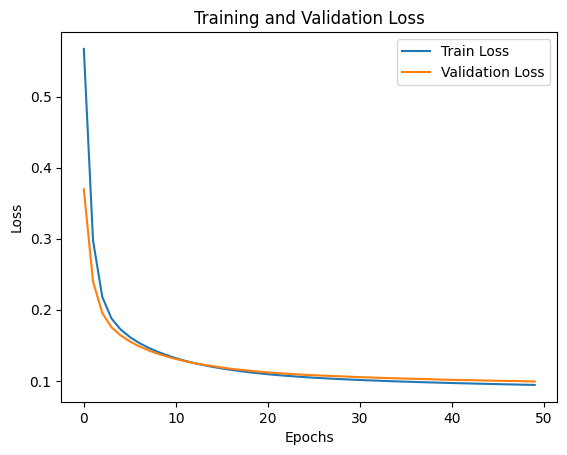

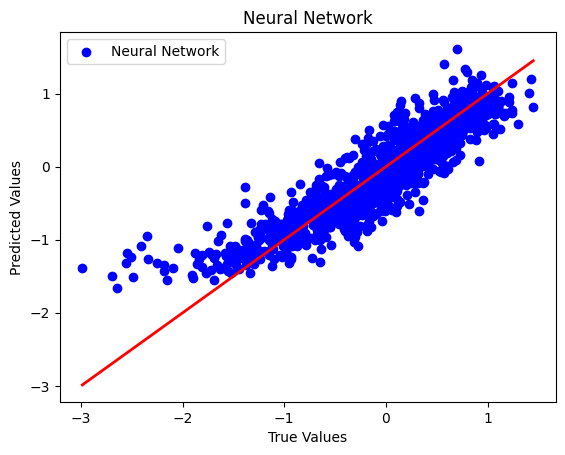

Best parameters for Neural Network : {'layers': 3, 'units': 64, 'activation': 'tanh', 'optimizer': 'sgd', 'learning_rate': 0.00019975632679838232, 'batch_size': 16, 'epochs': 50}
Neural Network MSE: 0.09901991017856074
Neural Network R2: 0.8141381440117444


In [32]:
predict_neural_network(NeuralNetworkModel(), "Neural Network", X_test, y_test, X_train, y_train)

### Analysis and Comparison of Model Performance

**SVM Analysis:** The SVM model outperforms all other models with the lowest MSE and the highest R² value, indicating it provides the most accurate predictions and explains a high proportion of the variance in the target variable. SVMs are effective in high-dimensional spaces and can capture complex relationships through the use of kernel functions, which have allowed it to better fit the data compared to other models.

**Decision Tree Analysis:** The Decision Tree model shows good performance with a relatively low MSE and a high R². It’s simpler than the SVM and performs well, making it a good choice for interpretability and computational efficiency. Decision trees partition the feature space into regions and make predictions based on the average target value within each region, which can effectively capture nonlinear relationships.

**Neural Network Analysis:** The Neural Network also performs well but slightly worse than the Decision Tree. Its R² value indicates it explains a significant portion of the variance, but its higher MSE suggests it might not be as accurate as SVM or Decision Tree. Neural networks are powerful for learning complex patterns but require extensive data and careful tuning of architecture and parameters to achieve optimal performance, which may not have been fully achieved in this case.

**KNN Analysis:** The KNN model has the highest MSE among the well-performing models and a lower R² value, indicating it’s less accurate and explains less variance compared to SVM, Decision Tree, and Neural Network. KNN relies on local similarity and can struggle with high-dimensional data or when the feature space is not well-defined, leading to poorer performance in this context.

**Linear Regression Analysis:** Linear Regression performs extremely poorly with an astronomical MSE and a highly negative R², indicating that it fails to model the data effectively. This result suggests that a linear relationship does not adequately capture the complex interactions and nonlinearity present in the dataset, highlighting the limitations of linear models when dealing with datasets with many features and potentially nonlinear relationships.

---

**Best Performing Model:** SVM, with the lowest MSE and highest R², making it the most accurate and reliable model.

**Good Alternatives:** Decision Tree and Neural Network, which also show strong performance and may be preferable for specific scenarios such as interpretability (Decision Tree) or flexibility (Neural Network).

**Least Effective:** Linear Regression, which is not suitable for the given data and performs poorly in comparison to other models.

This analysis indicates that the SVM model is the best choice for accurate predictions, while Decision Tree and Neural Network are also strong contenders depending on the specific needs and constraints of the task.

## PCA

In [63]:
pca = PCA(n_components=0.95)
df_X = df.drop(columns=['Avg Rating'])
X_pca = pca.fit_transform(df_X)
y_pca = df['Avg Rating']

X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(X_pca, y_pca, test_size=0.2, random_state=4)
print("Number of principal components:", pca.n_components_)

Number of principal components: 36


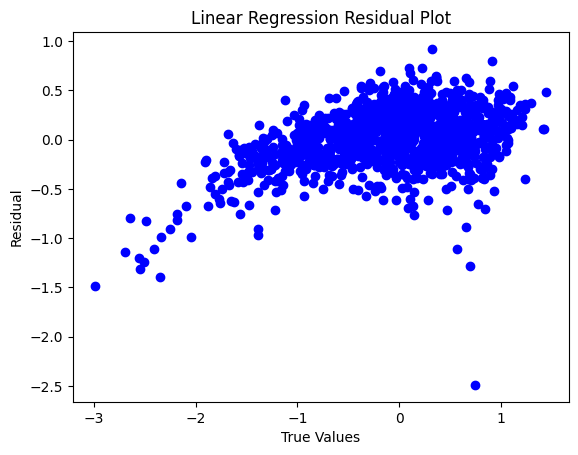

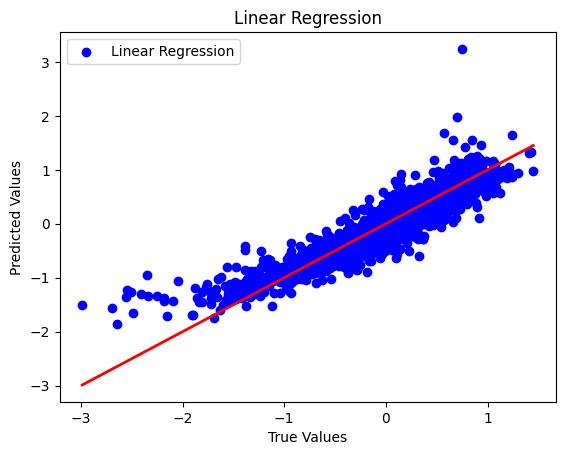

Best parameters for Linear Regression PCA : {'fit_intercept': True}
Linear Regression PCA MSE: 0.09230969981204051
Linear Regression PCA R2: 0.8267333094743679
100%|██████████| 50/50 [50:45<00:00, 60.90s/trial, best loss: 0.0466166736665231]    


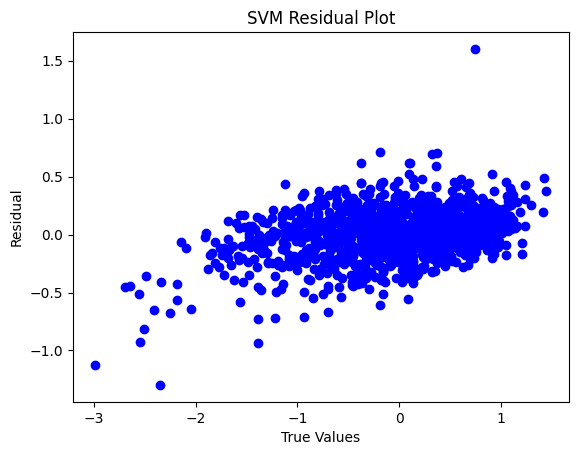

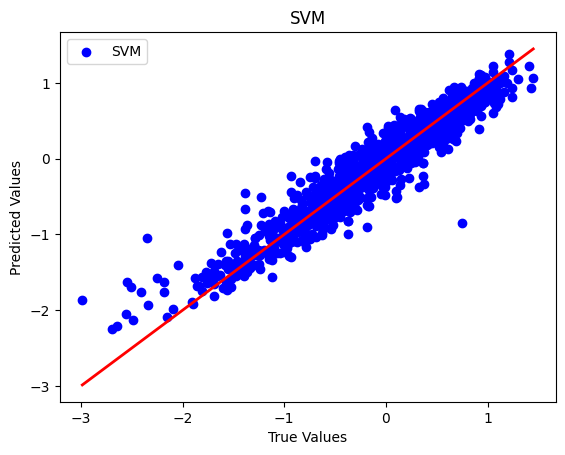

Best parameters for SVM PCA : {'C': 6.687267243622857, 'kernel': 'rbf', 'degree': 3, 'gamma': 0.03309350509443838, 'coef0': 0.6534166944616229, 'tol': 0.003229394018638688}
SVM PCA MSE: 0.049225084677129216
SVM PCA R2: 0.9076037780404775
100%|██████████| 100/100 [06:33<00:00,  3.93s/trial, best loss: 0.1373612077702702]


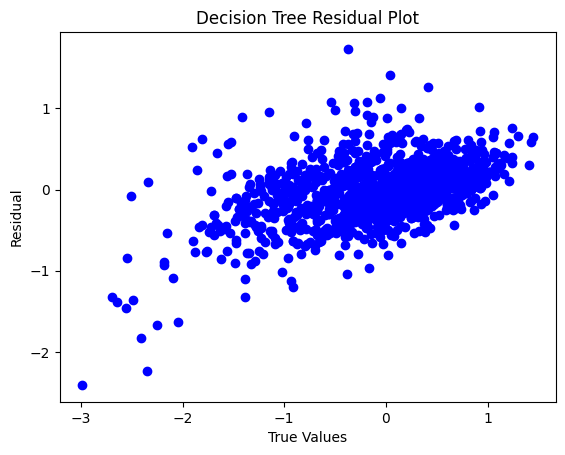

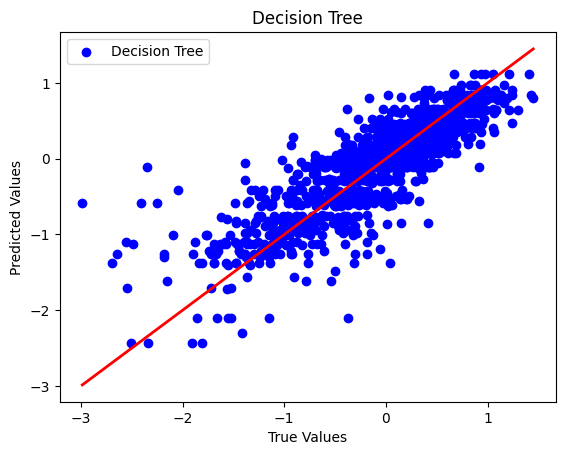

Best parameters for Decision Tree PCA : {'criterion': 'absolute_error', 'splitter': 'best', 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.00041351957756327693}
Decision Tree PCA MSE: 0.14677178992005174
Decision Tree PCA R2: 0.7245071498038429
100%|██████████| 100/100 [01:06<00:00,  1.50trial/s, best loss: 0.11373795736993102]


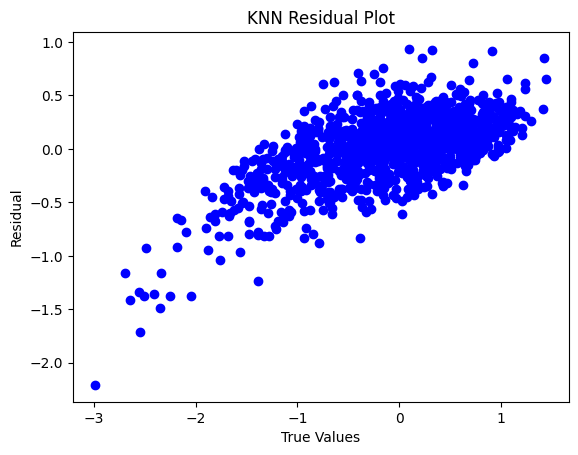

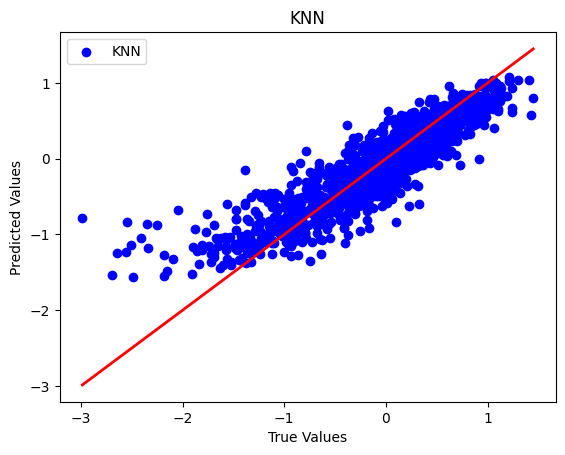

Best parameters for KNN PCA : {'n_neighbors': 20, 'weights': 'distance', 'algorithm': 'kd_tree', 'leaf_size': 10, 'p': 2}
KNN PCA MSE: 0.10826791267418748
KNN PCA R2: 0.7967795046742452


In [64]:
predict_with_tuning(LinearModel(), "Linear Regression PCA", X_pca_test, y_pca_test, X_pca_train, y_pca_train)
predict_with_tuning(SVMModel(), "SVM PCA", X_pca_test, y_pca_test, X_pca_train, y_pca_train)
predict_with_tuning(DecisionTreeModel(), "Decision Tree PCA", X_pca_test, y_pca_test, X_pca_train, y_pca_train)
predict_with_tuning(KNNModel(), "KNN PCA", X_pca_test, y_pca_test, X_pca_train, y_pca_train)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

c:\Users\shead\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning:

`fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.




100%|██████████| 50/50 [55:28<00:00, 66.57s/trial, best loss: 0.04477529098606918]    


c:\Users\shead\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


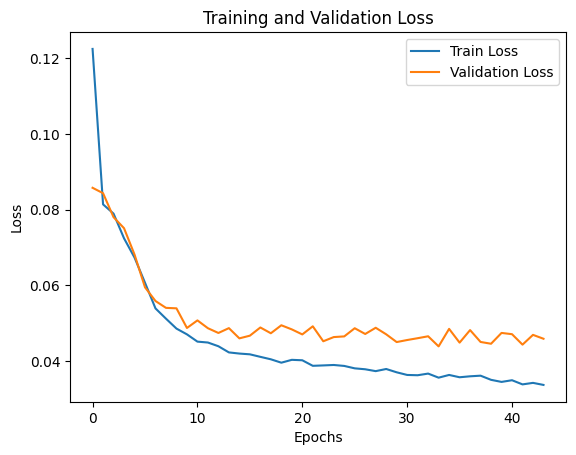

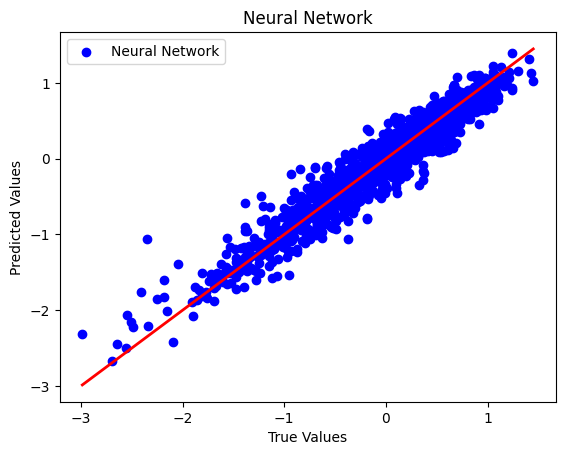

Best parameters for Neural Network : {'layers': 3, 'units': 64, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.0006149760253637152, 'batch_size': 32, 'epochs': 50}
Neural Network MSE: 0.04386841605585691
Neural Network R2: 0.9176583253539257


In [61]:
predict_neural_network(NeuralNetworkModel(), "Neural Network", X_pca_test, y_pca_test, X_pca_train, y_pca_train)

| Model                | MSE (without PCA)             | R² (without PCA)              | Best Parameters (without PCA)                                                                                                                                                 | MSE (with PCA)               | R² (with PCA)                | Best Parameters (with PCA)                                                                                                                                                   |
|----------------------|-------------------------------|-------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------------------|------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| SVM                  | 0.04695705954707458           | 0.9118608952135774            | {'C': 7.140774310833681, 'kernel': 'rbf', 'degree': 2, 'gamma': 0.03792286376119295, 'coef0': 0.4286955979138276, 'tol': 0.02599901583269276}                                 | 0.049225084677129216        | 0.9076037780404775          | {'C': 6.687267243622857, 'kernel': 'rbf', 'degree': 3, 'gamma': 0.03309350509443838, 'coef0': 0.6534166944616229, 'tol': 0.003229394018638688}                              |
| Decision Tree        | 0.08920426615168535           | 0.8325622550139183            | {'criterion': 'absolute_error', 'splitter': 'best', 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.00013058776793440093} | 0.14677178992005174         | 0.7245071498038429          | {'criterion': 'absolute_error', 'splitter': 'best', 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.00041351957756327693} |
| Neural Network       | 0.09901991017856074           | 0.8141381440117444            | {'layers': 3, 'units': 64, 'activation': 'tanh', 'optimizer': 'sgd', 'learning_rate': 0.00019975632679838232, 'batch_size': 16, 'epochs': 50}                                 | 0.04386841605585691         | 0.9176583253539257          | {'layers': 3, 'units': 64, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.0006149760253637152, 'batch_size': 32, 'epochs': 50}                               |
| KNN                  | 0.10784157301248723           | 0.7975797506112706            | {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'kd_tree', 'leaf_size': 20, 'p': 1}                                                                                    | 0.10826791267418748         | 0.7967795046742452          | {'n_neighbors': 20, 'weights': 'distance', 'algorithm': 'kd_tree', 'leaf_size': 10, 'p': 2}                                                                                  |
| Linear Regression    | 1.4548135694218079e+18        | -2.7307068814952376e+18       | {'fit_intercept': True}                                                                                                                                                        | 0.09230969981204051         | 0.8267333094743679          | {'fit_intercept': True}                                                                                                                                                       |


### Analysis and Comparison of Model Performance

**SVM Analysis:** The SVM model performs best among all models both with and without PCA, having the lowest MSE and highest R² values. SVMs are effective in handling high-dimensional data and can capture complex relationships through the use of kernel functions. The marginal drop in performance with PCA suggests that while dimensionality reduction may slightly affect its accuracy, SVMs still benefit from the reduced feature space by maintaining strong predictive capability.

**Decision Tree Analysis:** The Decision Tree model performs well without PCA but shows a significant drop in performance when PCA is applied, as evidenced by the higher MSE and lower R². Decision trees partition feature space into regions based on splits that maximize information gain, and PCA likely disrupts these splits by reducing the original feature set. Hence, the model struggles to capture the same level of variance in the target variable after dimensionality reduction.

**Neural Network Analysis:** The Neural Network shows improved performance with PCA, achieving a lower MSE and higher R². Neural networks are known for their ability to learn complex patterns, and PCA helps by reducing noise and focusing on the most informative components. This reduction in dimensionality likely improves the network's ability to generalize and make accurate predictions on the target variable.

**KNN Analysis:** The KNN model's performance remains relatively stable with and without PCA, showing only a slight increase in MSE and a negligible decrease in R². KNN relies on local similarity and does not explicitly benefit from dimensionality reduction like other models. Its stable performance suggests that the original feature space adequately represents the neighbors' distances for prediction, whether or not PCA is applied.

**Linear Regression Analysis:** Linear Regression performs extremely poorly without PCA, with an astronomical MSE and highly negative R², indicating it struggles to model the complex relationships present in the original feature space. However, with PCA, it shows a significant improvement, achieving a reasonable MSE and R². PCA reduces multicollinearity and focuses on the most relevant components, making the linear model more effective in explaining the variance in the target variable.

---

**Best Performing Model:** SVM, both with and without PCA, due to its lowest MSE and highest R² values.

**Improved with PCA:** Neural Network and Linear Regression show significant performance improvement with PCA.

**Stable Performance:** KNN remains stable with minimal changes in performance metrics.

**Drop in Performance with PCA:** Decision Tree shows a notable decline in performance with PCA.

**Least Effective without PCA:** Linear Regression is highly ineffective without PCA but improves significantly with PCA.

This analysis highlights the strengths and weaknesses of each model, with SVM being the most reliable choice for accurate predictions. Neural Network and Linear Regression benefit from PCA, while KNN remains consistent, and Decision Tree sees reduced effectiveness with PCA.

# Overall Report and Discussions

## ABOUT
**LETTERBOXD**  
Letterboxd is an online social cataloging service, launched in 2011. It has been described as "Goodreads for film" and experienced increased popularity during the COVID-19 pandemic.

---

This report encapsulates our journey from initializing the project to its conclusion. We began by scraping extensive movie data from Letterboxd, focusing on details like movie name, genre, studio, country, and average ratings. Using Selenium and Beautiful Soup, we navigated through dynamic web content to gather this information, ensuring robust data collection despite challenges in page loading and consistency. Thankfully we did not face any challenges regarding rate Limiting and did not have to use sleep. Subsequently, we meticulously cleaned and preprocessed the dataset, addressing data formatting inconsistencies and ensuring data quality by removing redundant characters and converting types where necessary. 

During Exploratory Data Analysis (EDA), we uncovered valuable insights. We observed high correlations between certain features and discovered that the majority of movies in our dataset are relatively new releases, predominantly of the drama genre, and primarily produced in English-speaking countries, particularly the United States. We also discovered that newer movies have lower average ratings due to various possible reasons.

In preparation for analysis, we undertook significant feature engineering, including removing collinear columns and introducing new features such as total engagement, positive engagement, and negative engagement based on numerical columns like watched, likes, raters, and the relation between these. We then did one-hot encoding for categorical columns. This step enriched our dataset and provided deeper insights into factors influencing movie ratings.

Moving into analysis and modeling, we deployed five distinct models—SVM, Linear Regression, Neural Network, K-Nearest Neighbors, and Decision Tree—to explore these factors. However, the journey was fraught with challenges, particularly in optimizing hyperparameters efficiently. Initial attempts using grid search proved time-consuming, leading us to adopt Bayesian optimization for parameter tuning. Even with this approach, the process required substantial time investment, delaying progress. Despite these challenges, our efforts culminated in a comprehensive analysis, highlighting significant findings and paving the way for future refinements and expansions in our modeling approach. 

We also trained and fine tuned our models with PCA as well to compare. SVM ended up being the most reliable and accurate model, Neural Networks and especially Linear Regression ended up benefitting from PCA, Decision Trees worsened and KNN did not really change. KNN performed the worst in general as well.
